# ` GPN Intelligence Cup 2020: Data Science`

# &1. Анализ исходных данных 

In [192]:
import pandas as pd
import numpy as np

## 1.1. Анализ данных по продажам

In [193]:
sales = pd.read_parquet('sales.parquet')
sales.head(5) # посмотрим на общий вид данных, в каждом из магазинов может продаваться несколько типов продукции

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


In [194]:
sales.info() # размер df, типы данных df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5081459 entries, 0 to 5081458
Data columns (total 6 columns):
date                  datetime64[ns]
shop_id               int64
owner                 object
number_of_counters    int32
goods_type            object
total_items_sold      float64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 213.2+ MB


In [195]:
sales.isna().values.any() # отлично, пропусков в данных по продажам нет

False

In [196]:
sales['owner'].value_counts() # все возможные владельцы магазинов, 5 видов

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

In [197]:
sales['goods_type'].value_counts() # все возможные типы товаров

Бензак                615722
Солярка               585314
Съедобный хлам        551292
Хлам                  540485
Патроны               505188
Броня и одежда        493856
Ядер-Кола             474912
Медпрепараты и еда    413378
Модификации тачки     353090
Жидкости для тачки    320589
Оружие                227633
Name: goods_type, dtype: int64

In [198]:
sales['total_items_sold'].value_counts()[-1] # total_items_sold содержит отрицательные значения!

10

In [199]:
len(set(sales['shop_id'])) # количество уникальных id магазинов

845

## 1.2. Анализ данных по характеристикам магазинов

In [200]:
shops = pd.read_parquet('shops.parquet') 
shops.head(5) # замечен первый None

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [201]:
shops.info() # размер df и типы данных
# количество строк в shops совпадает с количеством уникальных id, значит информация по характеристикам магазинов уникальна, данные есть по каждому магазину 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 8 columns):
shop_id                        845 non-null int32
neighborhood                   845 non-null object
city                           788 non-null object
year_opened                    845 non-null int32
is_on_the_road                 838 non-null object
is_with_the_well               785 non-null object
is_with_additional_services    784 non-null object
shop_type                      713 non-null object
dtypes: int32(2), object(6)
memory usage: 46.3+ KB


In [202]:
shops.isna().values.any() # подтверждение присутствия пропусков в данных 

True

In [203]:
for i in shops.columns:
    print(i, shops[i].isna().values.any()) # пропуски в колонках city, is_on_the_road, is_with_the_well, is_with_additional_services, shop_type 

shop_id False
neighborhood False
city True
year_opened False
is_on_the_road True
is_with_the_well True
is_with_additional_services True
shop_type True


In [204]:
shops['year_opened'].value_counts()[:2] # в значениях года присутствуют отрицательные значения (год открытия неизвестен)!

 2139    94
-1       63
Name: year_opened, dtype: int64

In [205]:
shops['shop_type'].value_counts() # все возможные типы магазинов

1    385
2    150
3    115
4     63
Name: shop_type, dtype: int64

In [206]:
shops['neighborhood'].value_counts() # все возможные значения neighborhood

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

## 1.3. Анализ данных о разбивке городов по локациям

In [207]:
cities = pd.read_parquet('cities.parquet')
cities.head(5)

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь


In [208]:
cities.info() # размер df и тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
city        15 non-null object
location    15 non-null object
dtypes: object(2)
memory usage: 368.0+ bytes


# &2. Отбор информативных признаков

In [209]:
from sklearn import preprocessing


## 2.1 Формирование признаков по типам продаваемой продукции

* Из таблицы sales видно, что в каждом из магазинов может продаваться несколько видов товара. Возможно, разные магазины специализируются на разных видах товаров, поэтому вклад признака __"вид товара"__, несомненно,  __будет влиять на результат итоговой кластеризации магазинов__
* Разбиение кластеров по типам продукции интуитивно логично. Например, в магазинах, специализирующихся на "Съедобном хламе", можно проводить одни промокампании и выстраивать определенные макркетинговые стратегии, а в магазинах, специализирующихся на "Солярке", будут использоваться совершеннно другие стратегии

In [210]:
# группирую данные, так, что каждому id соответствует уникальный тип товара и сумма всех проданных товаров данного типа товара
shop_info = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})
shop_info.head(10) # полученная группировка

,shop_id,goods_type,total_items_sold
0,0,Бензак,11647666.0
1,0,Броня и одежда,81.0
2,0,Жидкости для тачки,35.0
3,0,Съедобный хлам,1077.0
4,0,Хлам,1351.0
5,1,Бензак,9079168.0
6,1,Броня и одежда,1236.0
7,1,Жидкости для тачки,298.0
8,1,Солярка,1548661.0
9,1,Съедобный хлам,20340.0


In [211]:
goods = set(shop_info['goods_type']) # получаю множество уникалных типов товаров
ids = set(shop_info['shop_id']) # получаю множество уникальных shop id  
X = pd.DataFrame({"shop_id":pd.Series(list(ids))}) # создаю колонку со списком shop_id, чтобы потом добавлять к ней сформированные признаки признаки

In [212]:
# поочередно создаю колонки вида shop_id - количество проданного товара определенного типа и добавляю их к X
for type_i in goods:
    feature = sales[sales['goods_type'] == type_i].groupby('shop_id').aggregate({'total_items_sold' : 'sum'})
    feature = feature.rename(columns={'total_items_sold': type_i})
    X = pd.merge(left=X, right=feature, left_on='shop_id', right_on='shop_id',  how='outer')

In [213]:
# таким образом, X содержит информацию о количестве проданного товара определенного типа по каждому shop_id
X.head(10) 

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,Модификации тачки
0,0,1077.0,NaN,NaN,NaN,81.0,35.0,1351.0,NaN,NaN,11647666.0,NaN
1,1,20340.0,1548661.0,NaN,NaN,1236.0,298.0,5321.0,NaN,NaN,9079168.0,NaN
2,2,115414.0,1378414.0,2526.0,47141.0,21571.0,3550.0,39997.0,636472.0,3109.0,7953184.0,5527.0
3,3,32051.0,2399400.0,30.0,5.0,754.0,13286.0,17724.0,NaN,NaN,23048831.0,61.0
4,4,289664.0,3258548.0,844.0,161995.0,13826.0,15438.0,79956.0,797282.0,37541.0,23389524.0,16925.0
5,5,284567.0,2451011.0,8778.0,237754.0,38255.0,12466.0,86394.0,860789.0,48769.0,21835937.0,17291.0
6,6,70612.0,3223573.0,NaN,12318.0,1378.0,4980.0,18157.0,NaN,NaN,11627584.0,211.0
7,7,44845.0,921224.0,476.0,29458.0,3843.0,2539.0,39762.0,102628.0,111.0,11104626.0,1675.0
8,8,237388.0,997187.0,535.0,165528.0,4444.0,12815.0,62788.0,215113.0,10689.0,4228536.0,6542.0
9,9,80611.0,5883914.0,77.0,44894.0,468.0,12806.0,59839.0,NaN,NaN,9175262.0,543.0


### Требуется обработка полученных данных:
* данные содержат nan 
* необходима нормализация признаков: значения ячеек слишком большие, удобнее рассматривать долю каждого из типов товаров в сумме общих продаж магазина, а не количество проданного товара

In [ ]:
X1 = X.fillna(0)# заполняем nan нулями
df = X.drop(columns=['shop_id']) # убираем shop_id, нормализация данного признака не требуется 
normalized_X =pd.DataFrame(preprocessing.normalize(df), columns = df.columns) # нормализация
data1 = pd.concat([X["shop_id"], normalized_X], axis=1)
data1.head(10)

In [214]:
X = X.fillna(0)# заполняем nan нулями
df = X.drop(columns=['shop_id']) # убираем shop_id, нормализация данного признака не требуется 
normalized_X =pd.DataFrame(preprocessing.normalize(df), columns = df.columns) # нормализация
data1 = pd.concat([X["shop_id"], normalized_X], axis=1)
data1.head(10)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,Модификации тачки
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,1.000000,0.000000
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,0.985760,0.000000
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,0.982130,0.000683
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,0.994624,0.000003
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,0.989765,0.000716
5,5,0.012939,0.111443,0.000399,1.081028e-02,0.001739,0.000567,0.003928,0.039139,0.002217,0.992844,0.000786
6,6,0.005852,0.267153,0.000000,1.020853e-03,0.000114,0.000413,0.001505,0.000000,0.000000,0.963634,0.000017
7,7,0.004024,0.082670,0.000043,2.643527e-03,0.000345,0.000228,0.003568,0.009210,0.000010,0.996516,0.000150
8,8,0.054447,0.228715,0.000123,3.796553e-02,0.001019,0.002939,0.014401,0.049338,0.002452,0.969858,0.001500
9,9,0.007395,0.539790,0.000007,4.118575e-03,0.000043,0.001175,0.005490,0.000000,0.000000,0.841738,0.000050


## 2.2 Формирование признаков по характеристикам магазинов 

* Добавим ещё некоторые наборы признаков из данных по характеристикам магазинов. Такие признаки как neighborhood, is_on_the_road, is_with_additional_services, shop_type - носят ограмный информативный характер
* __Почему эти признаки важны?__ В реальной жизни в магазин у дома люди чаще заходят за продуктами для приготовления ужина, в магазин около бизнес-центра зайдут скорее за обедом или фруктами. Возможно, и в нашем случае в магазине "В центе" и в магазине "На отшибе" спрос на товары может сильно отличаться, поэтому признаки __neighborhood, is_on_the_road, shop_type__  могут потенциально внести огромный вклад в итоговою кластеризацию
* __is_with_additional_services__ - весомый бинарный признак. Представим ситуацию: у нас есть два типа АЗС. В АЗС первого типа на территории есть минимаркет, в АЗС другого типа соответственно минимаркета нет. Понятно, что прогнозировать спрос для этих двух типов АЗС нужно по-разному, более того, в данном случае будут использоваться разные стратегии управления и маркетинга, будут планироваться разные промокампании 


In [215]:
shops.head(5)# заметим, что shop_id не отсортированы 

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [216]:
shops = shops.sort_values('shop_id') # отсортируем shop_id, чтобы впоследствие было удобнее конкатенировать признаки
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
259,0,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None
770,1,В центре,Нефтеперегонный Завод,2115,нет,нет,нет,None
592,2,Промзона,Нефтеперегонный Завод,2115,нет,нет,да,2
701,3,У ночлега,Нефтеперегонный Завод,2092,нет,нет,нет,3
628,4,В центре,Нефтеперегонный Завод,2108,нет,нет,да,1


Как было замечено в пункте 1.2 строки is_on_the_road, is_with_the_well, is_with_additional_services, shop_type содержат nan, более того, эти строки имеют тип object

In [217]:
shops = shops.replace('да', 1) # преобразуем категориальные признаки в числовые
shops = shops.replace('нет', 0) # преобразуем категориальные признаки в числовые
shops[['is_on_the_road', 'is_with_the_well', 'is_with_additional_services']] = shops[['is_on_the_road', 'is_with_the_well', 'is_with_additional_services']].fillna(0)
shops['shop_type'] = shops['shop_type'].fillna('1') # заменяем None на медианное значение shop_type (т.к значения shop_type имеют тип object)

In [218]:
# преобразуем категориальный признак neighborhood с помощью dummy-кодирования в набор бинарных признаков
(pd.get_dummies(shops["neighborhood"])).head(5)

,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
259,1,0,0,0,0,0,0
770,1,0,0,0,0,0,0
592,0,0,1,0,0,0,0
701,0,0,0,0,0,1,0
628,1,0,0,0,0,0,0


In [219]:
# добавим полученные признаки к признакам из пункта 2.1
neigh_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["neighborhood"])], axis=1) 
data2 = pd.merge(left=data1, right=neigh_id, left_on='shop_id', right_on='shop_id',  how='outer')
data2.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,Модификации тачки,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,1.000000,0.000000,1,0,0,0,0,0,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,0.985760,0.000000,1,0,0,0,0,0,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,0.982130,0.000683,0,0,1,0,0,0,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,0.994624,0.000003,0,0,0,0,0,1,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,0.989765,0.000716,1,0,0,0,0,0,0


* Признак __shop_type__ в данном случае является категориальнм (числовые значения лишь кодируют тип), поэтому необходимо также использовать dummy-кодирование для обработки данного признака

In [220]:
type_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["shop_type"])], axis=1) 
data3 = pd.merge(left=data2, right=type_id, left_on='shop_id', right_on='shop_id',  how='outer')
# переименуем столбцы с типом для более удобной работы
for i in range(1, 5):
    data3 = data3.rename(columns={f'{i}': f'shop_type_{i}'})
data3.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,1,0,0,0,0,0,1,0,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,0,0,0,1,0,0,0


* добавим признаки is_on_the_road, is_with_the_well, is_with_additional_service к уже сформированным признакам

In [221]:
data4 = pd.merge(left=data3, right=shops[['shop_id','is_on_the_road', 'is_with_the_well', 'is_with_additional_services']], left_on='shop_id', right_on='shop_id',  how='outer')
data4.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,1,0,0,0,0.0,0.0,0.0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,1,0,0,0,0.0,0.0,0.0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,0,0,0,1,0,0,0.0,0.0,1.0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,1,0,0,0,1,0,0.0,0.0,0.0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,1,0,0,0,0.0,0.0,1.0


## 2.3 Формирование гипотетически информативных признаков

* Возможно, такие признаки как __year__ - год основания магазина и __city__ - локация магазина __способны улучшить итоговую кластеризацию__ 
* Вполне логично, что новые магазины привлекают больше посетителей, соответственно спрос в таких магазинах может быть выше. Но это лишь предположение, которое будет проверено на практике при построении кластеров
* Каждый регион имеет свои особенности и свою сезонность: например в Сибири и на Дальнем Востоке заморозки начинаются с первой половины осени, а значит спрос, например, на дизельное топливо упадет раньше, чем в Санкт-Петербурге и Ленинградской области. Данный признак также гипотетически может внести вклад в итоговую клвстеризацию
* Проверки требует и признак __owner__ из характеристик по продажам. Возможно, от владельца группы магазинов и от реализуемой стратегии зависит уровень продаж товаров в данных магазинах. Проверим, как полияет этот признак на итоговую клвстеризацию

Нормализуем значения признака "year" и добавим его к уже сформированным признакам: 

In [222]:
year = shops["year_opened"]
mean_value = round(shops[year!= -1]["year_opened"].mean())
year = year.replace(-1, mean_value) # заменяем -1 на медианное значение столбца year
year = (year-year.min())/(year.max()-year.min()) # нормализация данных
year_id = pd.concat([shops['shop_id'], year], axis=1) 
data5 = pd.merge(left=data4, right=year_id, left_on='shop_id', right_on='shop_id',  how='outer') # формируем набор с признаками
data5.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services,year_opened
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,1,0,0,0,0.0,0.0,0.0,0.898551
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,1,0,0,0,0.0,0.0,0.0,0.594203
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,0,0,1,0,0,0.0,0.0,1.0,0.594203
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,1,0,0,0,1,0,0.0,0.0,0.0,0.260870
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,1,0,0,0,0.0,0.0,1.0,0.492754


Заменим пропуски и обработаем признак city с помощью dummy-кодированния:

In [223]:
city_id = pd.concat([shops['shop_id'], pd.get_dummies(shops['city'])], axis=1) 
city_id = city_id.fillna(0)
data5 = pd.merge(left=data5, right=city_id, left_on='shop_id', right_on='shop_id',  how='outer')
data5.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,Лагерь,Нефтеперегонный Завод,Пасть,Равнина Маяка,Свинцовая Ферма,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,1,0,0,0,0,0,0,0,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,1,0,0,0,0,0,0,0,0


In [224]:
data5.isna().values.any() # убедились, что в признаках нет nan

False

Сформируем признак owner и добавим его к признакам:

In [225]:
shop_owners = sales.groupby(['shop_id','owner'],as_index=False).aggregate({'total_items_sold': 'sum'})
print(shop_owners.shape) # у некоторых shop id менялись owners, поэтому строк больше, чем уникальных shop_id
shop_owners.head(5)

(1002, 3)


,shop_id,owner,total_items_sold
0,0,Рейдеры,11650210.0
1,1,Рейдеры,10655024.0
2,2,Рейдеры,10206905.0
3,3,Рейдеры,25512142.0
4,4,Рейдеры,28061543.0


In [226]:
shop_owners = shop_owners.drop_duplicates(subset ="shop_id") # удалим дубликаты shop id, чтобы учитывать только текущих владельцев
print(shop_owners.shape) # 845 - как раз столько, сколько имеется уникальных shop id
shop_owners.head(5)

(845, 3)


,shop_id,owner,total_items_sold
0,0,Рейдеры,11650210.0
1,1,Рейдеры,10655024.0
2,2,Рейдеры,10206905.0
3,3,Рейдеры,25512142.0
4,4,Рейдеры,28061543.0


In [227]:
owners_dummy = pd.get_dummies(shop_owners["owner"]) # обработка признака
id_owners = pd.concat([shop_owners['shop_id'], owners_dummy], axis=1)
data6 = pd.merge(left=data5, right=id_owners, left_on='shop_id', right_on='shop_id', how = 'outer')
data6.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель,Бомбисты,Воины полураспада,Последователи Апокалипсиса,Рейдеры,Стервятники
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,0,0,0,0,0,0,0,1,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,0,0,0,0,0,1,0


### `Таким образом, были получены 6 тестовых наборов с признаками:`

* __data1__: признаки по типам продаваемой продукции, профили продаж
* __data2__: data1 + признаки по окрестности магазина (neighborhood)
* __data3__: data2 + признаки по типу магазина (shop type)¶
* __data4__: data3 + признаки is_on_the_road, is_with_the_well, is_with_additiona
* __data5__: data4 + признаки year, city
* __data6__: data5 + признак owner

## 2.4 Оценка  тенденции кластеризации

Прежде чем строить кластеризацию, важно убедиться, что набор данных (признаков),имеет тенденцию кластеризации и не содержит равномерно распределенных точек. Ведь если данные не содержат тенденцию кластеризации, то построенные кластеры не возможно будет интерпретировать и они не будут значимыми. Для этого используется критерий Хопкинса, если H > 0.5, то вероятно, данные содержат кластеры

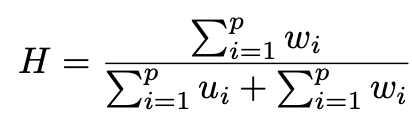

In [228]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

In [229]:
def hopkins(X):
    d = X.shape[1]
    n = len(X) 
    m = int(0.1 * n) 
    ujd, wjd  = [], []
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
    rand_X = sample(range(0, n, 1), m)
 
    for j in range(m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
    
    return sum(ujd) / (sum(ujd) + sum(wjd))

In [230]:
hopkins(data6.drop(columns='shop_id')) # чем ближе значение критерия к 1, тем больше тенденция классификации 

0.8341026707820968

Таким образом, построенное признаковое описание объектов обладает тенденцией кластеризации, а значит можно переходить к кластрезации объектов

# & 3. Выбор метрик качества кластеризации

Прежде чем проводить кластеризацию, необходимо определить метрики качества, которые будут использоваться для проверки качества кластеризации

### 1) среднее внутрикластерное расстояние

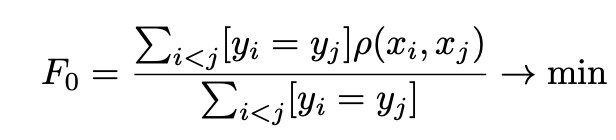

### 2) среднее межкластерное расстояние

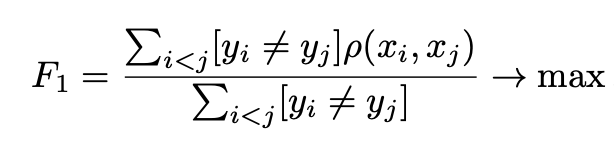

### 3) комбинация функционалов

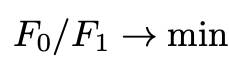

Но так или иначе эти функционалы имеют ряд недостатков. Например, с помощью таких функционалов нельзя подобрать количество кластеров. Действительно, при использовании таких метрик лучшим вариантом будет отнести каждую точку к своему собственному кластеру, так как в этом случае среднее внутрикластерное расстояние будет равно нулю.

### 4) Коэффициент силуэта 

Коэффициент силуэта — метрика качества, которая позволяет выбрать количество кластеров, выбирается число кластеров, максимизирующее значение силуэта. Коэффициент силуэта определяется по формуле:

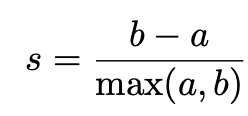

где a — среднее расстояние от данного объекта до других объектов из того же кластера, b — среднее расстояние от данного объекта до объектов из ближайшего другого кластера

  Данная величина лежит в диапазоне [−1,1]. Значения, близкие к -1, соответствуют разрозненным кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным", четко выделенным кластерам. Таким образом, __чем больше силуэт, тем более четко выделены кластеры__, и они представляют собой компактные, плотно сгруппированные облака точек

__Так как число кластеров в решаемой задаче нам заранее неизвестно, то логично использовать коэффициент силуэта в том числе и для выбора оптимального количества кластеров__

In [ ]:
????? написать ещё о некоторых коэфф

# & 4. Реализация алгоритмов кластеризации и проверка качества

Проводить первичную кластеризацию будем на всех собранных признаках: data6 (47 признаков)

In [394]:
data6.head(10)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель,Бомбисты,Воины полураспада,Последователи Апокалипсиса,Рейдеры,Стервятники
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,0,0,0,0,0,0,0,1,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,0,0,0,0,0,1,0
5,5,0.012939,0.111443,0.000399,1.081028e-02,0.001739,0.000567,0.003928,0.039139,0.002217,...,0,0,0,0,0,0,0,0,1,0
6,6,0.005852,0.267153,0.000000,1.020853e-03,0.000114,0.000413,0.001505,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
7,7,0.004024,0.082670,0.000043,2.643527e-03,0.000345,0.000228,0.003568,0.009210,0.000010,...,0,0,0,0,0,0,0,0,1,0
8,8,0.054447,0.228715,0.000123,3.796553e-02,0.001019,0.002939,0.014401,0.049338,0.002452,...,0,0,0,0,0,0,0,0,1,0
9,9,0.007395,0.539790,0.000007,4.118575e-03,0.000043,0.001175,0.005490,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0


## 4.1. DBSCAN

Для начала применим алгоритм __DBSCAN, основанный на плотности точек__ в окрестности каждого объекта выборки. Согласно данному алгоритму, все точки делятся на __основные, пограничные и шумовые__. Далее, соединяются основные точки, находящиеся на расстоянии eps друг от друга, в результате получается граф. Каждая группа __основных точек объединяется в свой кластер__ (выделяются связные компоненты в получившемся графе). Пограничные точки относятся к соответствующим им кластерам

In [231]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [395]:
shop_id = data6['shop_id']
X = data6.drop(columns=['shop_id']) # уберем из признаков метки объектов, их не нужно включать в кластеризацию

In [407]:
def dbscan_alg(X_np, eps=1.4, min_samples=5):
    """
    Input: X_np - признаковое описание объектов; 
            eps - эпсилон окрестность точек, которые будут объединяться в кластер;
            min_samples - число объектов в окрестности точки, которая будет считаться основной.
    Output: algo_labels - метки кластеров;
            s - значение коэффициента силуэта
    """
    dbscan = DBSCAN(eps, min_samples)
    dbscan.fit(X_np)
    algo_labels = dbscan.labels_
    s = metrics.silhouette_score(X_np, algo_labels)
    
    return algo_labels, s

# параметры eps и min_samples подбирались эмпирическим образом конкретно для поставленной задачи

In [413]:
labels, s = dbscan_alg(X.to_numpy())
print(f" Получено {max(labels)} кластеров","\n",f"Коэффициент силуэта:{s}") 

 Получено 30 кластеров 
 Коэффициент силуэта:0.0910901970431888


C таким набором признаков __коэффициент силуэта невелик__, это говорит о том, что построенные кластеры пересекаются/ накладываются друг на друга. Возможно, мы выделили слишком много признаков и не все они являются информативными. Проверим информативность каждого из признаков по построенной кластеризации.

### Проверка информативности признаков по построенной кластеризации

In [414]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

In [420]:
def X_importance(X_df, labels):
    """
    Input: X_df - признаковое описание объектов; 
           labels - метки кластеров, полученные в результате кластеризации
    Output: диаграмма информативности признаков
    """
    n = X_df.shape[1]
    model = ExtraTreesClassifier()
    model.fit(X_df, labels)

    fig = plt.figure(figsize=(15,10))
    feat_importances = pd.Series(model.feature_importances_, index=X_df.columns)
    feat_importances.nlargest(n).plot(kind='barh')
#     features = feat_importances.nlargest(n) если захотим вывести информативность каждого признака
    plt.show()

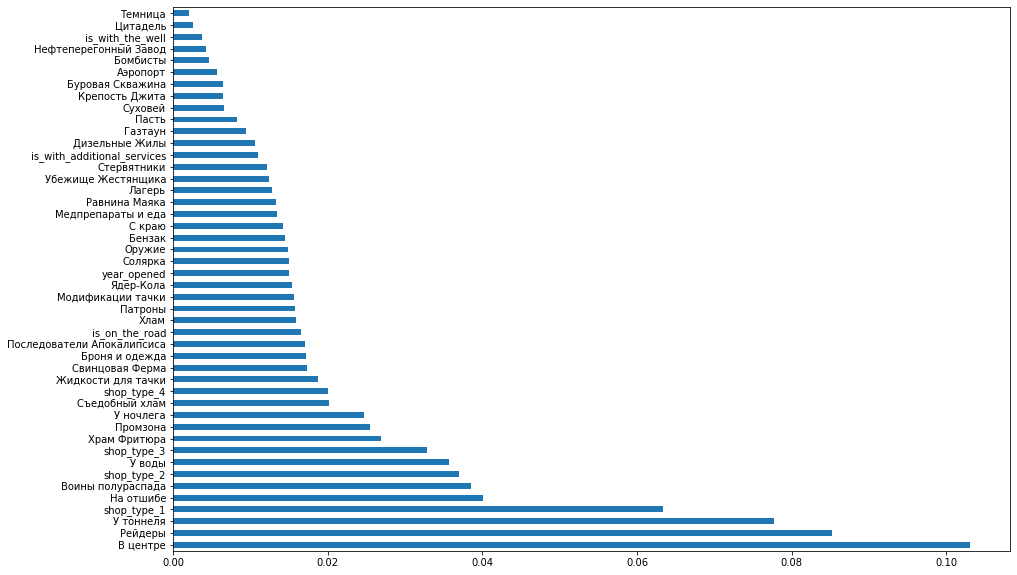

In [421]:
X_importance(X, labels)

Таким образом, из данной диаграммы были выделены основные информативные признаки, эти признаки совпадают с набором признаков data3, полученным на этапе 2. Далее для проведения кластеризации будут использоваться признаки data3.

In [425]:
data3.head(5)

,shop_id,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,...,0,1,0,0,0,0,0,1,0,0
3,3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
4,4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,...,0,0,0,0,0,0,1,0,0,0


In [426]:
shop_id = data3['shop_id']
X_1 = data3.drop(columns=['shop_id']) # уберем из признаков метки объектов, их не нужно включать в кластеризацию

In [427]:
labels1, s1 = dbscan_alg(X_1.to_numpy())
print(f" Получено {max(labels1)} кластеров","\n",f"Коэффициент силуэта:{s1}") 

 Получено 23 кластеров 
 Коэффициент силуэта:0.8914130382919782


Видно, что __значение коэффициента силуэта значительно улучшилось__ и стало близким к 1, значит кластеры стали "плотными" и четко выделенным. __Количество сформированных кластеров при этом уменьшилось__.

Проанализируем признаки X_1 с точки зрения их взаимосвязи, построим корреляционную матрицу.

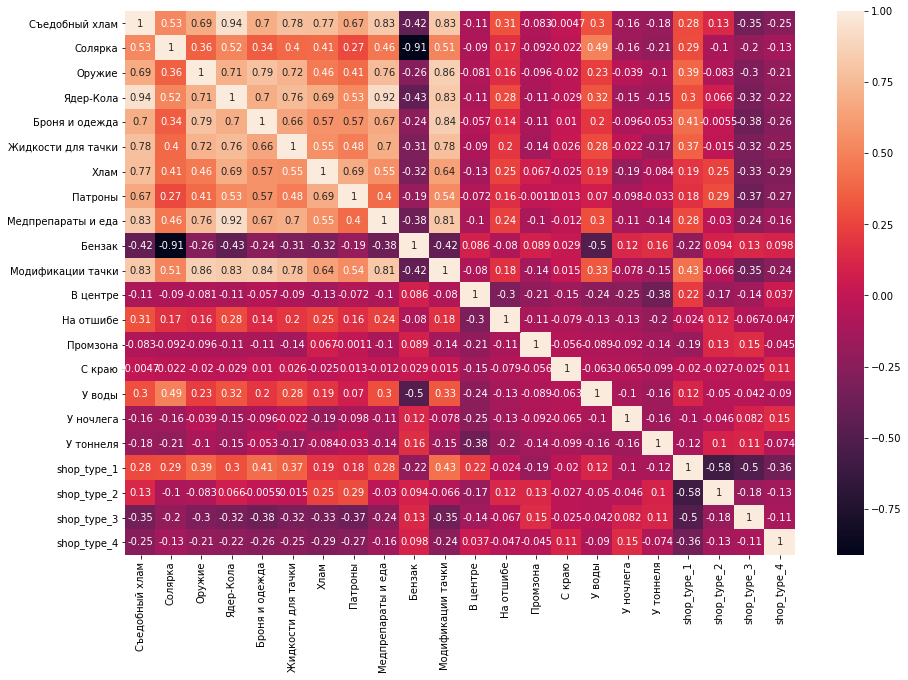

In [429]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(X_1.corr(), annot = True)

Предсказание и запись в df

In [252]:
import numpy as np
from sklearn.cluster import KMeans
from typing import Tuple

### Запись результата в csv файл

In [1689]:
metrics.silhouette_score(d, X_test_clstrs['clusters'])
X_test_clstrs = X_test_clstrs.sort_values('clusters')
X.to_csv('out1.csv', index=False)  

-0.2179605461215871

In [1561]:
X_test_clstrs = X_test_clstrs.sort_values('clusters')

In [362]:
new_idea

,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Модификации тачки,...,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,clusters
0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,1
1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,1
2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,0.000683,...,1,0,0,0,0,0,1,0,0,9
3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,0.000003,...,0,0,0,1,0,0,0,1,0,2
4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,0.000716,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,0.013707,0.198716,0.000622,9.116804e-03,0.002700,0.000866,0.006279,0.022609,0.005366,0.001505,...,0,0,0,0,0,1,0,0,0,1
841,0.013597,0.175535,0.000686,7.572002e-03,0.001612,0.000982,0.004801,0.027760,0.003974,0.000891,...,0,0,0,0,0,1,0,0,0,1
842,0.021839,0.212102,0.001175,1.703058e-02,0.002015,0.001725,0.005090,0.029397,0.008594,0.001520,...,0,0,0,0,0,1,0,0,0,1
843,0.013668,0.141825,0.000813,7.861145e-03,0.002083,0.000676,0.004365,0.034893,0.004297,0.000727,...,0,0,0,0,0,1,0,0,0,1


In [366]:
col = ['Съедобный хлам', 'Солярка', 'Оружие', 'Ядер-Кола', 'Броня и одежда','Жидкости для тачки', 'Хлам', 'Патроны', 'Медпрепараты и еда']
new_idea[col] = pd.DataFrame(preprocessing.normalize(new_idea[col]), columns = col )

In [367]:
new_idea

,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Модификации тачки,...,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,clusters
0,0.622542,0.000000,0.000000,0.000000,0.046821,0.020231,0.780923,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,1
1,0.013133,0.999908,0.000000,0.000000,0.000798,0.000192,0.003436,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,1
2,0.075728,0.904436,0.001657,0.030931,0.014154,0.002329,0.026244,0.417616,0.002040,0.000683,...,1,0,0,0,0,0,1,0,0,9
3,0.013356,0.999868,0.000013,0.000002,0.000314,0.005536,0.007386,0.000000,0.000000,0.000003,...,0,0,0,1,0,0,0,1,0,2
4,0.085896,0.966279,0.000250,0.048037,0.004100,0.004578,0.023710,0.236423,0.011132,0.000716,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,0.068240,0.989300,0.003096,0.045388,0.013442,0.004313,0.031262,0.112555,0.026715,0.001505,...,0,0,0,0,0,1,0,0,0,1
841,0.076166,0.983297,0.003842,0.042416,0.009028,0.005503,0.026895,0.155505,0.022260,0.000891,...,0,0,0,0,0,1,0,0,0,1
842,0.101032,0.981211,0.005438,0.078786,0.009322,0.007980,0.023548,0.135995,0.039755,0.001520,...,0,0,0,0,0,1,0,0,0,1
843,0.092947,0.964474,0.005528,0.053460,0.014165,0.004598,0.029686,0.237286,0.029222,0.000727,...,0,0,0,0,0,1,0,0,0,1


### 4.2. K-Means

In [261]:
from sklearn import datasets
from sklearn.cluster import KMeans

In [262]:
def kmeans_alg(X_df, n):

    model = KMeans(n_clusters=n) 
    model.fit(X_df)
    labels = model.predict(X_df)

    return labels, metrics.silhouette_score(X_df, labels)

In [372]:
test = new_idea
test['clusters'], s = kmeans_alg(new_idea, 10)
# test = pd.concat([data3['shop_id'], test], axis=1)

In [373]:
s

0.623802720524665

In [356]:
test = test.sort_values('clusters')
test.head(10)

,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Модификации тачки,...,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,clusters
493,0.000000,0.140497,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,0,1,0
750,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,0,1,0,0,0,1,0
438,0.000000,0.133968,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,0,1,0
765,0.000000,0.137661,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,1,0
443,0.000000,0.252748,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,0,1,0
355,0.000000,0.136028,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,1,0
354,0.000000,0.112042,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,0,1,0
54,0.000000,0.543068,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,1,0
353,0.000000,0.149844,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,0,1,0
784,0.001162,0.101839,1.712963e-07,0.0,0.000055,0.000042,0.000863,0.000423,0.0,0.000044,...,0,1,0,0,0,0,0,0,1,0


In [357]:
test.columns

Index(['Съедобный хлам', 'Солярка', 'Оружие', 'Ядер-Кола', 'Броня и одежда',
       'Жидкости для тачки', 'Хлам', 'Патроны', 'Медпрепараты и еда',
       'Модификации тачки', 'В центре', 'На отшибе', 'Промзона', 'С краю',
       'У воды', 'У ночлега', 'У тоннеля', 'shop_type_1', 'shop_type_2',
       'shop_type_3', 'shop_type_4', 'clusters'],
      dtype='object')

In [358]:
k = test.groupby('clusters').aggregate({'Съедобный хлам': 'mean', 'Солярка': 'mean', 'Оружие': 'mean', 'Ядер-Кола': 'mean',
       'Броня и одежда': 'mean', 'Жидкости для тачки': 'mean', 'Хлам': 'mean', 'Патроны': 'mean',
       'Медпрепараты и еда': 'mean', 'Бензак': 'mean', 'Модификации тачки': 'mean', 'В центре': 'mean',
       'На отшибе': 'mean', 'Промзона': 'mean', 'С краю': 'mean', 'У воды': 'mean', 'У ночлега': 'mean', 'У тоннеля': 'mean',
       'shop_type_1': 'mean', 'shop_type_2': 'mean', 'shop_type_3': 'mean', 'shop_type_4': 'mean', 'clusters': 'mean'})

feature_lst = ['Съедобный хлам', 'Солярка', 'Оружие', 'Ядер-Кола','Броня и одежда', 'Жидкости для тачки', 'Хлам', 'Патроны', 'Медпрепараты и еда', 'Бензак', 'Модификации тачки']
k[feature_lst] = k[feature_lst]*100

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


KeyError: 'Бензак'

In [359]:
k = test.groupby('clusters').aggregate({'Съедобный хлам': 'mean', 'Солярка': 'mean', 'Оружие': 'mean', 'Ядер-Кола': 'mean',
       'Броня и одежда': 'mean', 'Жидкости для тачки': 'mean', 'Хлам': 'mean', 'Патроны': 'mean',
       'Медпрепараты и еда': 'mean',  'Модификации тачки': 'mean', 'В центре': 'mean',
       'На отшибе': 'mean', 'Промзона': 'mean', 'С краю': 'mean', 'У воды': 'mean', 'У ночлега': 'mean', 'У тоннеля': 'mean',
       'shop_type_1': 'mean', 'shop_type_2': 'mean', 'shop_type_3': 'mean', 'shop_type_4': 'mean', 'clusters': 'mean'})

feature_lst = ['Съедобный хлам', 'Солярка', 'Оружие', 'Ядер-Кола','Броня и одежда', 'Жидкости для тачки', 'Хлам', 'Патроны', 'Медпрепараты и еда', 'Модификации тачки']
k[feature_lst] = k[feature_lst]*100

In [360]:
k

,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Модификации тачки,...,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,clusters
clusters,,,,,,,,,,,,,,,,,,,,,
0,0.270769,14.813218,0.004858,0.126730,0.035527,0.020566,0.131206,0.713840,0.037692,0.015661,...,0.031746,0.111111,0.000000,0.253968,0.095238,0,0,0,1,0
1,1.609764,22.276000,0.062921,1.171554,0.218853,0.123849,0.469698,2.774500,0.584143,0.124020,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,1
2,0.328502,14.802870,0.002923,0.066604,0.023246,0.031059,0.204475,0.785485,0.012103,0.008583,...,0.253165,0.037975,0.088608,0.227848,0.000000,0,0,1,0,2
3,1.678831,20.272338,0.087735,1.168406,0.270358,0.179563,0.488186,3.423865,0.625132,0.157621,...,0.246575,0.246575,0.000000,0.506849,0.000000,1,0,0,0,3
4,2.790938,32.816810,0.105629,2.284923,0.298552,0.184501,0.653966,3.407441,1.346966,0.196904,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,4
5,1.159752,17.109657,0.067809,0.841726,0.210231,0.101080,0.459255,2.768012,0.450956,0.110263,...,0.000000,0.000000,0.000000,0.000000,1.000000,1,0,0,0,5
6,3.322510,50.804776,0.134820,2.795810,0.353550,0.239414,0.720206,3.443825,1.738038,0.274403,...,0.000000,0.000000,1.000000,0.000000,0.000000,1,0,0,0,6
7,0.268263,13.743881,0.005279,0.084637,0.036017,0.019992,0.158007,0.625652,0.033049,0.011637,...,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,1,0,7
8,1.579623,15.212795,0.035367,1.164321,0.234857,0.094876,0.553074,3.867636,0.376590,0.080193,...,0.000000,0.000000,0.000000,0.000000,1.000000,0,1,0,0,8


In [361]:
k.to_csv('res15_.csv', index=True)  

In [332]:
k['В центре']

clusters
0     1.000000
1     0.000000
2     0.875000
3     0.511628
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.794118
13    0.000000
14    0.000000
Name: В центре, dtype: float64

## 4.3. Иерархическая кластеризация

In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

### Минимальное межкластерное расстояние

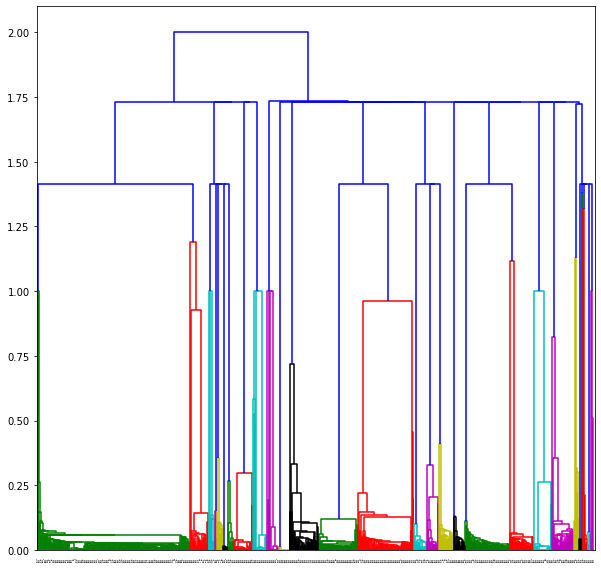

In [375]:
mergings3 = linkage(df3.to_numpy(), method='single')
mergings4 = linkage(new_idea.to_numpy(), method='single')

fig = plt.figure(figsize=(10, 10))
dendrogram(mergings4,leaf_font_size=2)

plt.show()


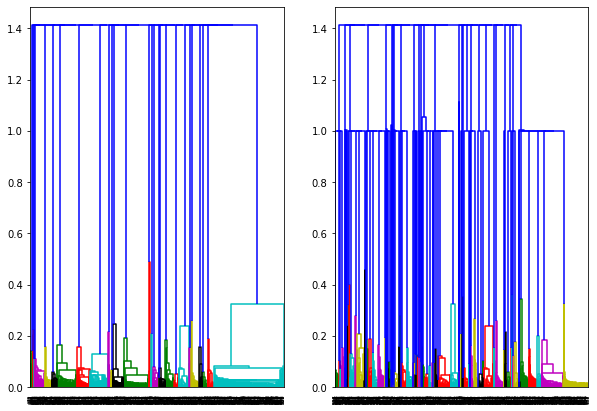

In [141]:
mergings3 = linkage(df3.to_numpy(), method='single')
mergings4 = linkage(df4.to_numpy(), method='single')

fig, axes = plt.subplots(1, 2, figsize=(10, 7))
dn1 = hierarchy.dendrogram(mergings3, ax=axes[0],
                          orientation='top')
dn2 = hierarchy.dendrogram(mergings4, ax=axes[1],
                        orientation='top')
plt.show()

In [ ]:
len(set(dendrogram(mergings)['color_list']))

### Максимальное межкластерное расстояние

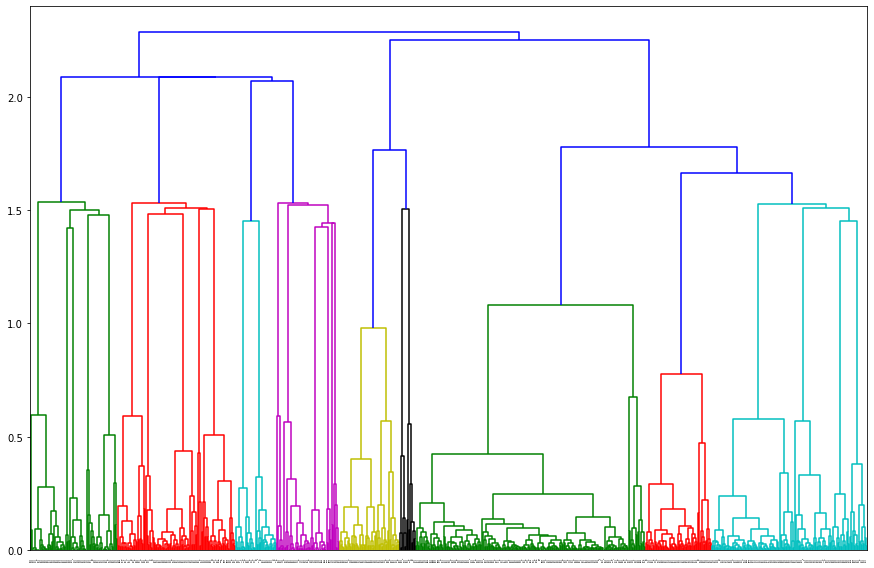

In [75]:
mergings = linkage(df3.to_numpy(), method='complete')

fig = plt.figure(figsize=(15,10))
dendrogram(mergings, leaf_font_size=2)

plt.show()

### Метод невзвешенного попарного среднего

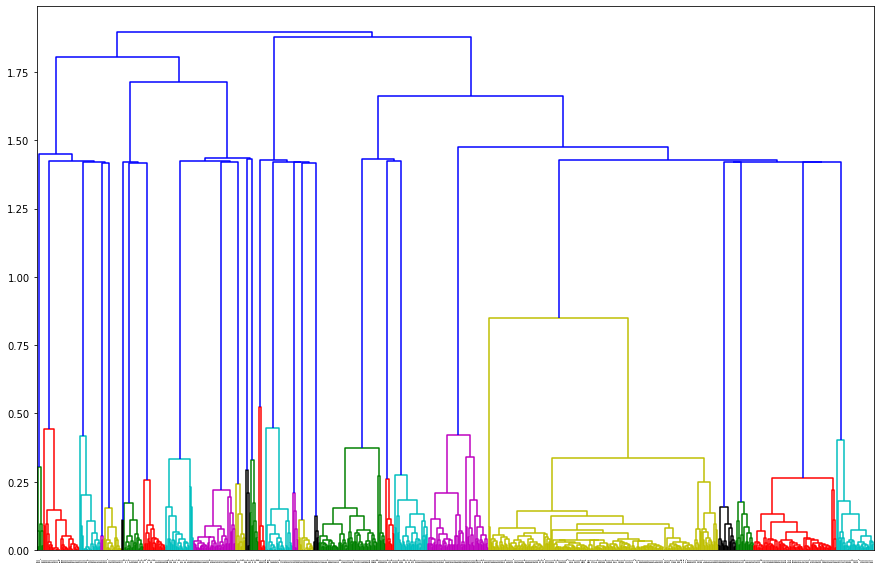

In [76]:
mergings = linkage(df3.to_numpy(), method='average')

fig = plt.figure(figsize=(15,10))
dendrogram(mergings,
           leaf_font_size=2)

plt.show()

### Метод взвешенного попарного среднего

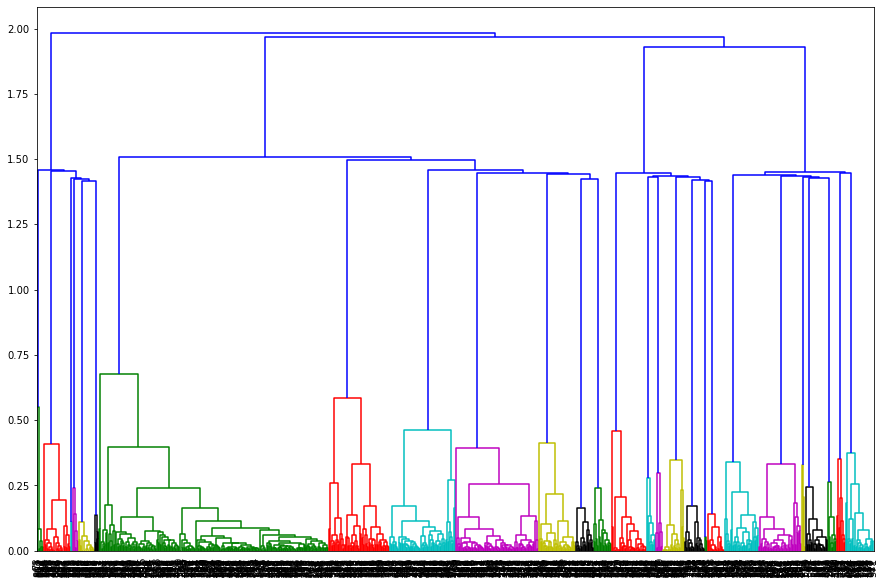

In [1779]:
mergings = linkage(df3.to_numpy(), method='weighted'
                  )
fig = plt.figure(figsize=(15,10))
dendrogram(mergings,
#            labels=varieties,
           leaf_rotation=90,
           leaf_font_size=10,
           )
# plt.figure(figsize=(20,10))
# plt.figure(figsize=(1,1))
plt.show()

In [ ]:
настоить размер:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html 

In [ ]:
повекра качества результатов 

In [88]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

In [90]:
alg = AgglomerativeClustering(n_clusters=25)
alg.fit(df3)
alg.labels_

array([ 2,  2, 20, 19,  2, 15,  2,  2,  2, 22, 16,  2,  2, 10, 13, 13, 18,
        6,  6,  4, 11, 18, 13,  7,  2,  6,  2,  3,  2, 15,  2, 15,  2,  6,
        2, 10, 15,  2,  4,  1,  2, 17, 13,  2, 16,  2, 17, 12, 18,  3, 18,
        2,  3, 10,  7, 14,  2,  0, 17,  2,  2,  6,  2,  2,  2,  2, 20, 20,
       17,  2, 17,  2, 20, 23, 10, 20,  2, 20,  4,  6, 18,  2,  2, 20, 17,
        7,  3,  4,  8,  2,  3,  2,  1, 10,  6,  3,  1, 20, 10,  1, 10,  2,
       10,  2,  3,  3,  2,  3,  2, 10, 12,  2,  1,  2,  2, 20,  2,  6,  3,
        2,  2,  2,  2,  6,  2,  2,  2, 15,  2,  2,  2,  8,  2,  2,  8,  6,
        2,  2,  6,  2,  7,  2,  2,  2,  2,  2, 14, 14,  0,  2,  2,  4, 12,
        8,  3,  2,  2,  2, 14,  2,  0,  2,  6,  6,  2,  8, 18,  8,  4,  8,
        8,  8,  1,  8,  3,  8,  8, 12,  6, 14, 19, 14, 22,  8,  8,  2, 16,
        3,  8, 15,  2,  8,  2, 11,  8,  8, 10,  4,  2,  8,  6, 20, 11,  4,
       11, 11, 11,  2, 18, 19,  2, 11, 17, 11,  2,  2, 19,  2,  9, 11, 14,
        2,  4,  4,  9,  9

In [601]:
for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=5)
    clustering.fit(data)
    
    print(metrics.silhouette_score(data, clustering.labels_))

0.12082585223821937
0.17942524589922335
0.12336133554669082
0.017129940042098838


In [ ]:
0.5494873408232994
0.5539784808859305
0.5532355555181032
0.4302314021185118

In [ ]:
варианты алгоритмов

In [ ]:
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

In [390]:
print(metrics.silhouette_score(data2, algo_labels))
print(metrics.silhouette_score(data2, all_predictions))

0.1850243270794171
0.5344327316650442


In [392]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility

def show_cluster(data2):
    data2 = data2.to_numpy()

    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 21, 22, 25, 26, 27]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([0, 0.6])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0.6, len(data2) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data2)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data2, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data2, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data2[:, 0], data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

Automatically created module for IPython interactive environment


For n_clusters = 2 The average silhouette_score is : 0.3088303836734968
For n_clusters = 3 The average silhouette_score is : 0.3294203866530001
For n_clusters = 4 The average silhouette_score is : 0.3809030921984341
For n_clusters = 5 The average silhouette_score is : 0.4215416566061837
For n_clusters = 6 The average silhouette_score is : 0.4792340408540932
For n_clusters = 7 The average silhouette_score is : 0.5342365711595984
For n_clusters = 8 The average silhouette_score is : 0.5726766376165473
For n_clusters = 9 The average silhouette_score is : 0.5969604298215309
For n_clusters = 10 The average silhouette_score is : 0.603336881036852
For n_clusters = 11 The average silhouette_score is : 0.6328824569754403
For n_clusters = 12 The average silhouette_score is : 0.6583227377126524
For n_clusters = 13 The average silhouette_score is : 0.6901499656973336
For n_clusters = 14 The average silhouette_score is : 0.709451752884768
For n_clusters = 15 The average silhouette_score is : 0.72565

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For n_clusters = 27 The average silhouette_score is : 0.8483781622400173


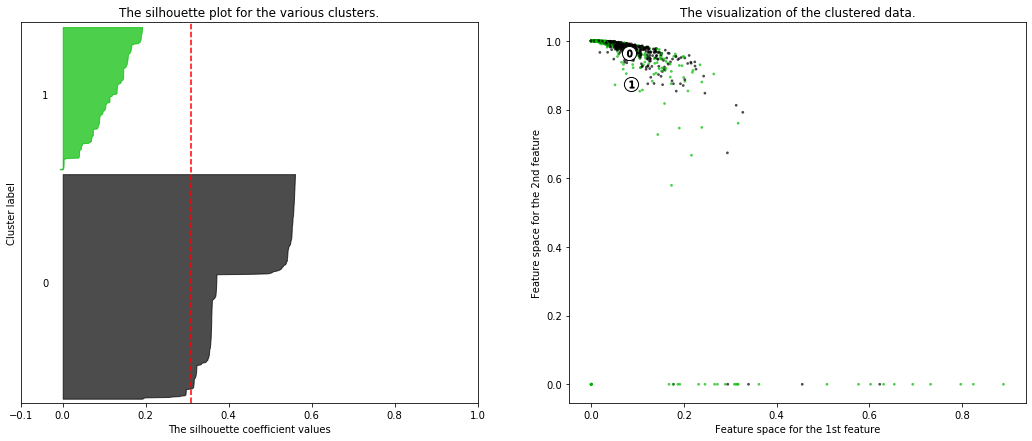

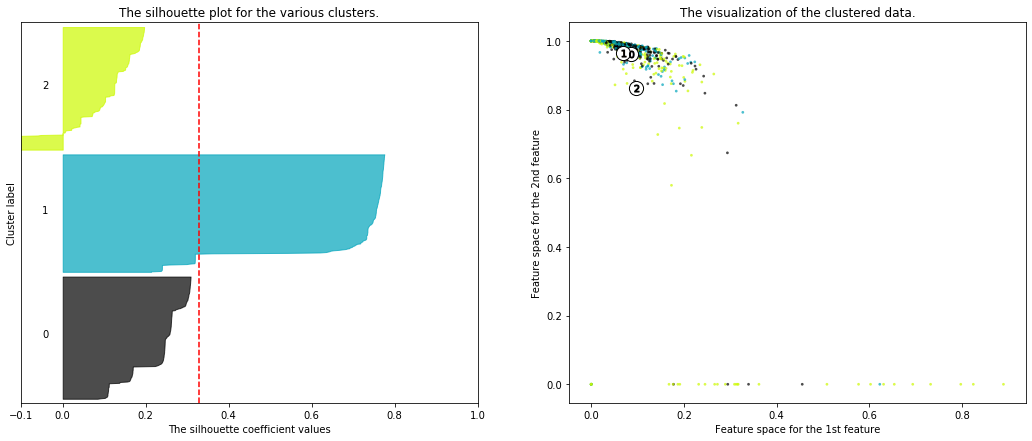

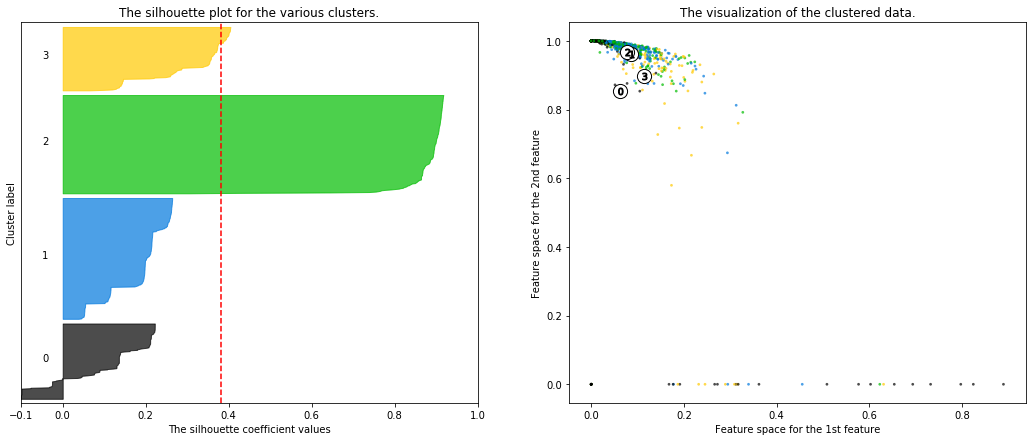

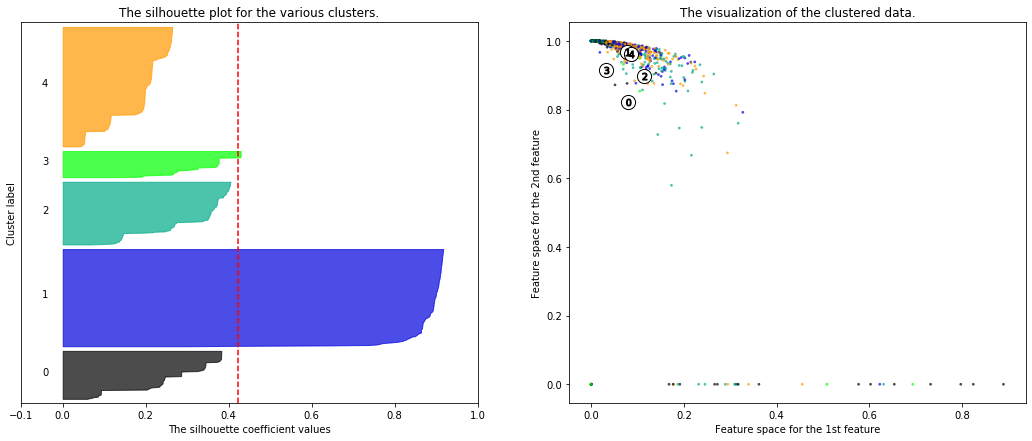

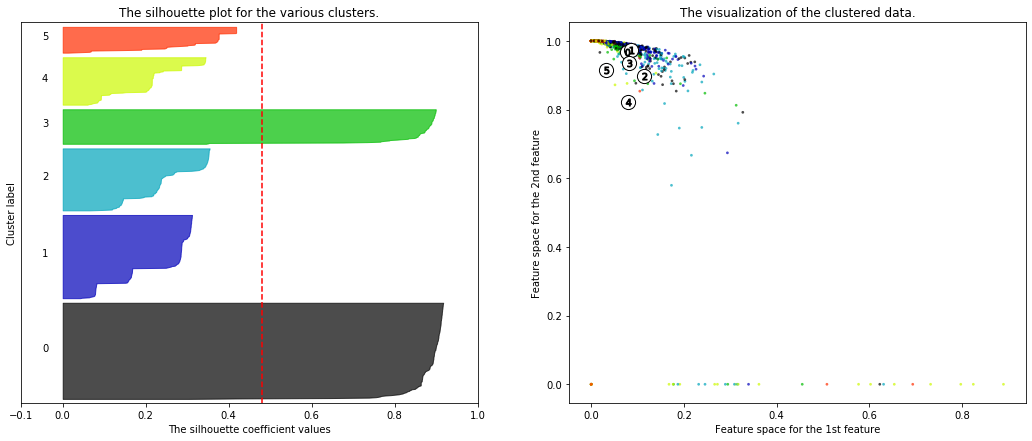

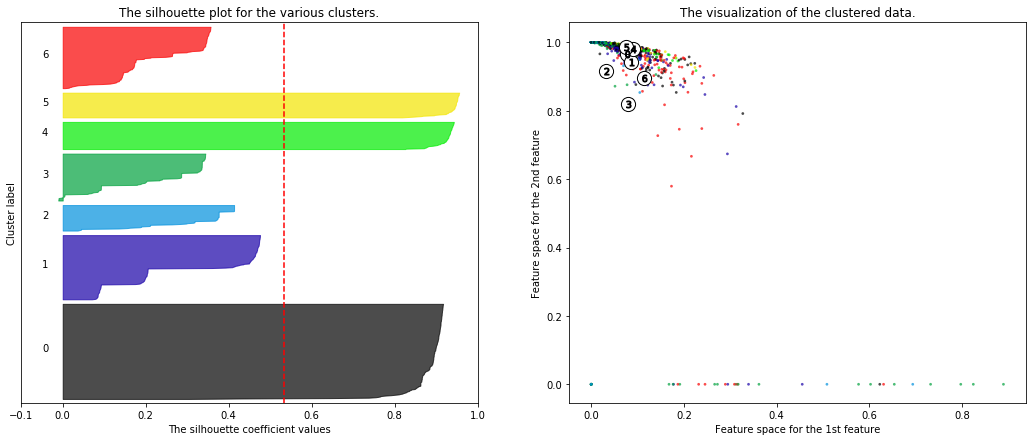

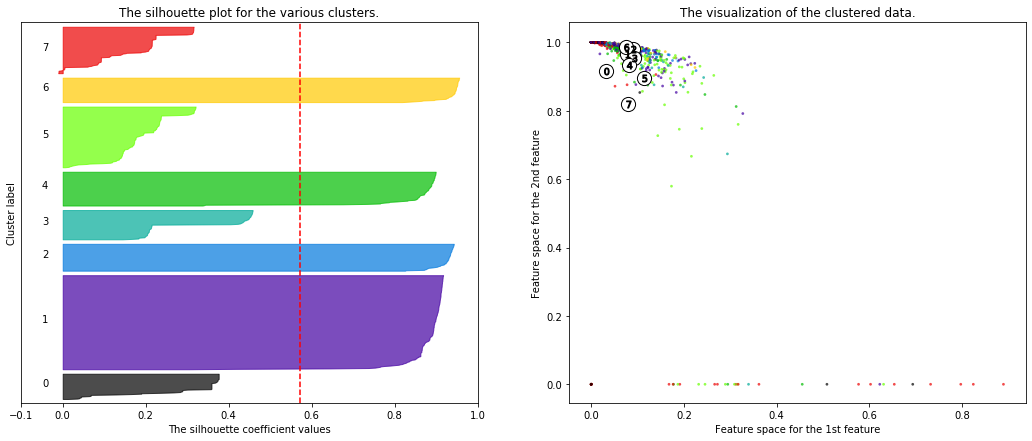

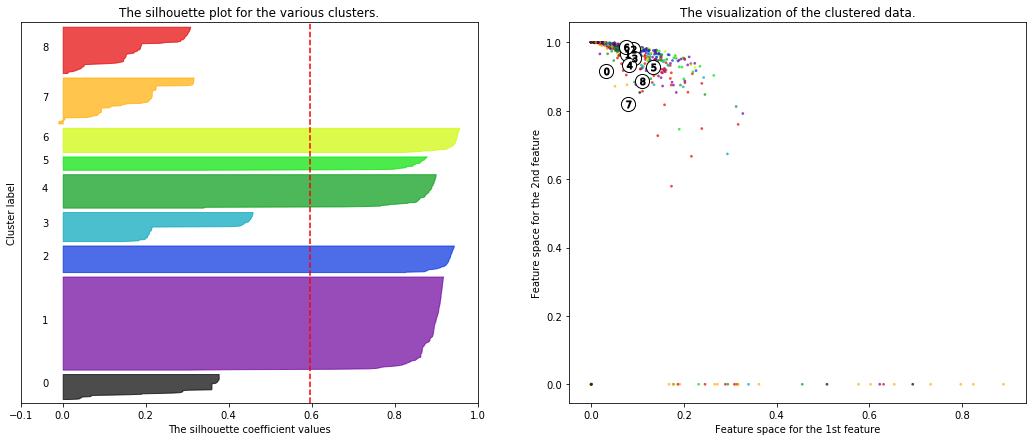

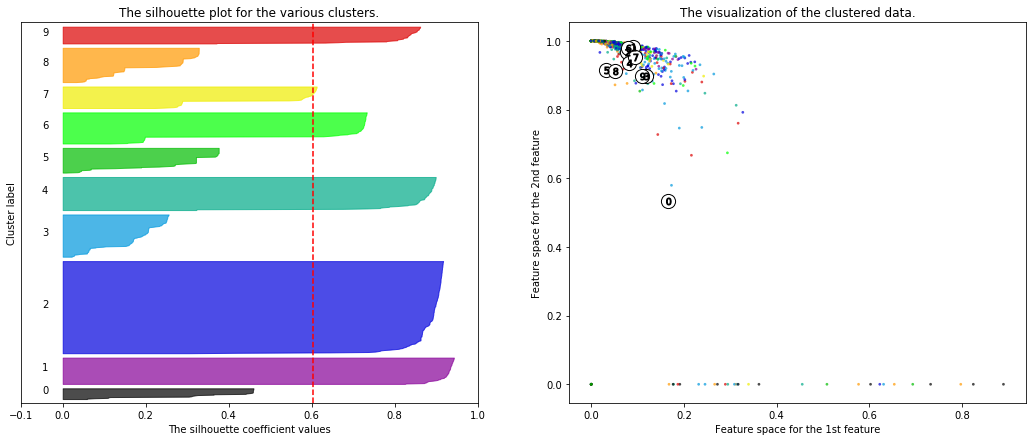

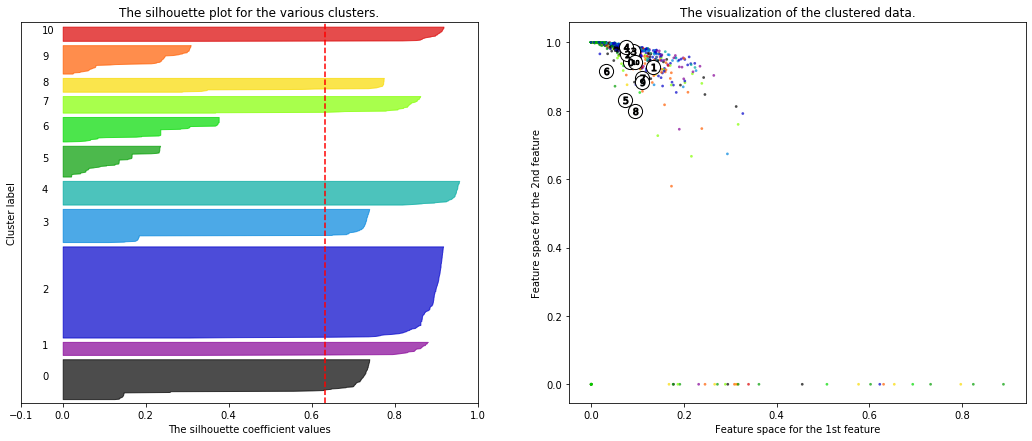

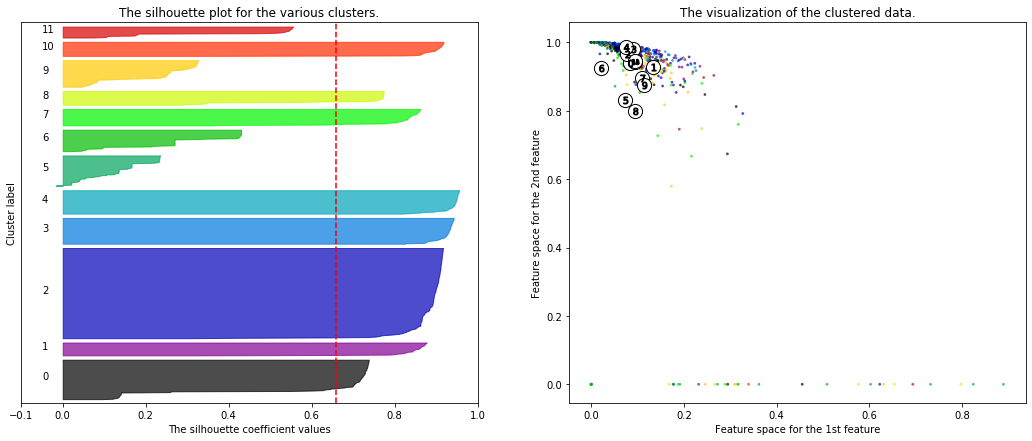

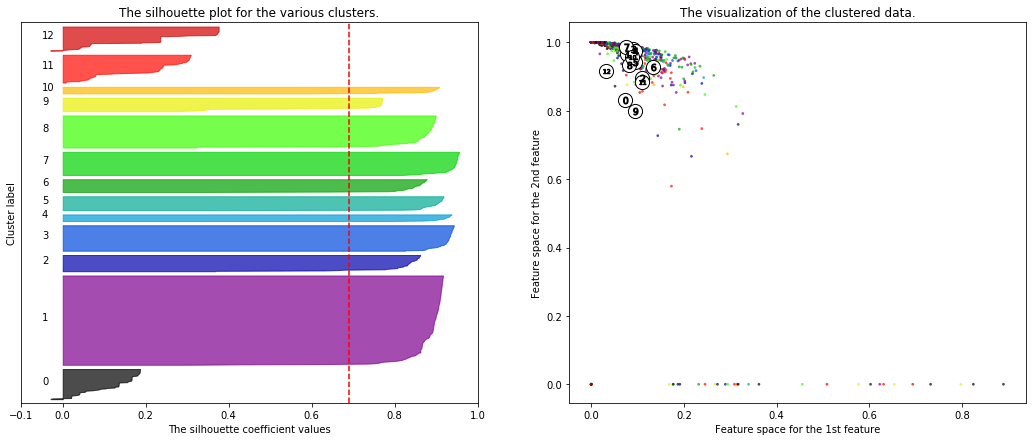

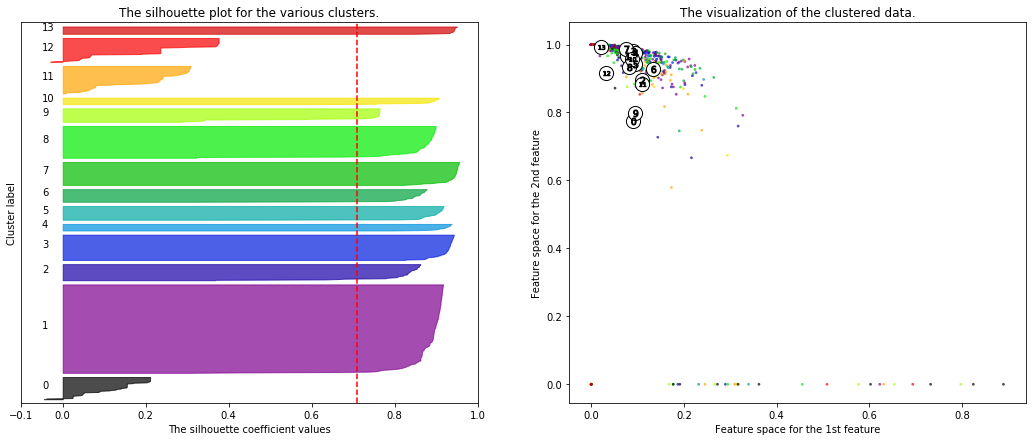

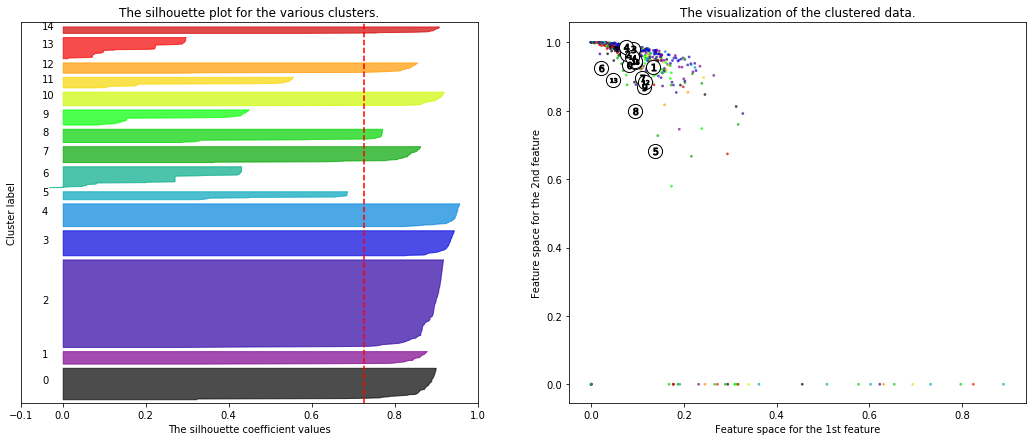

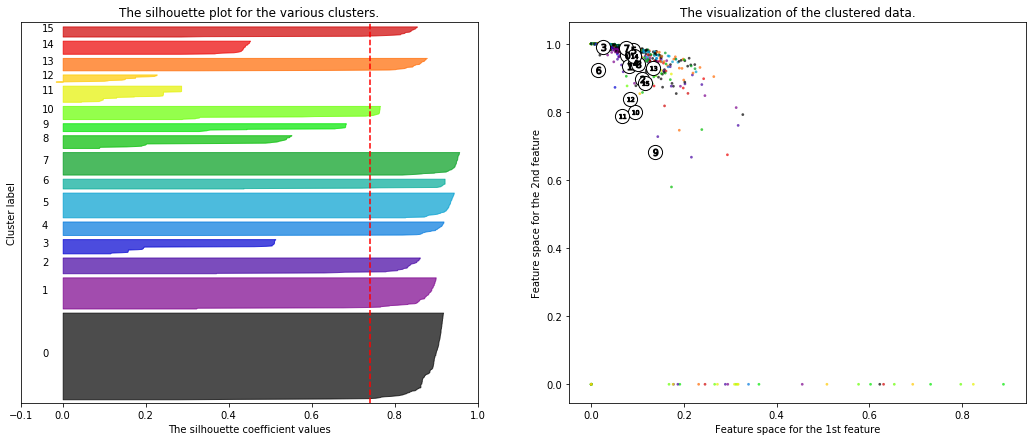

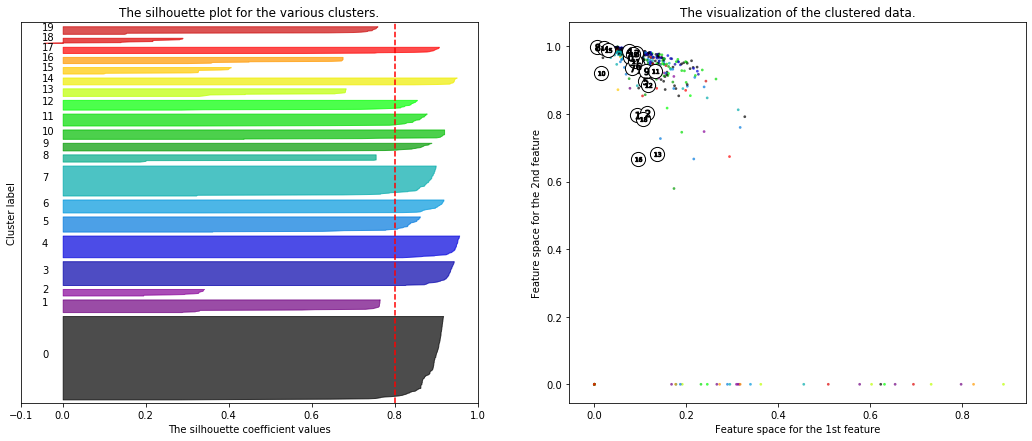

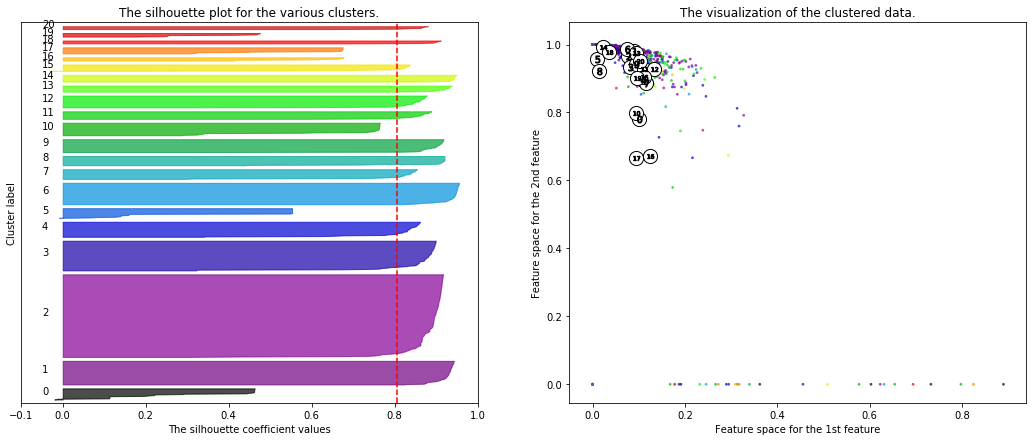

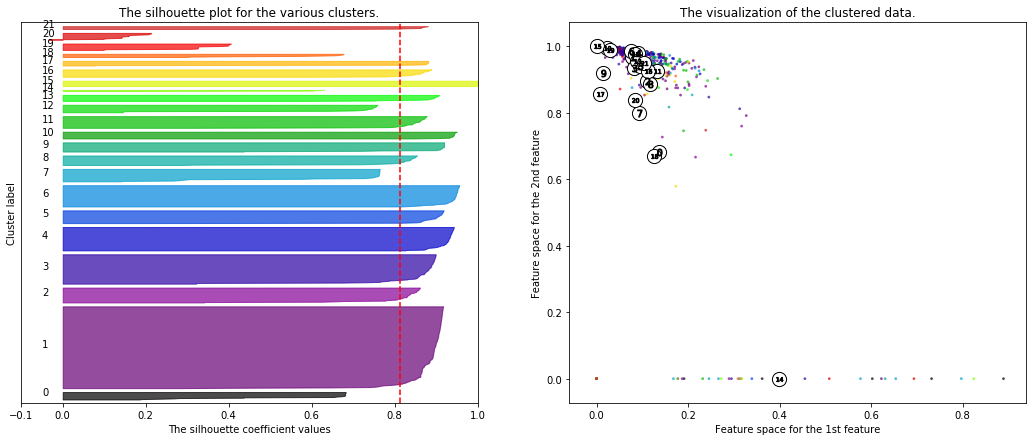

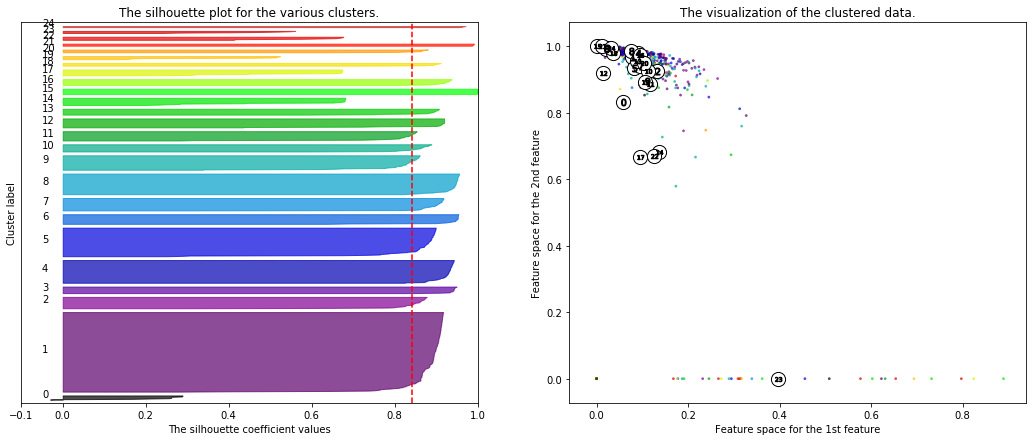

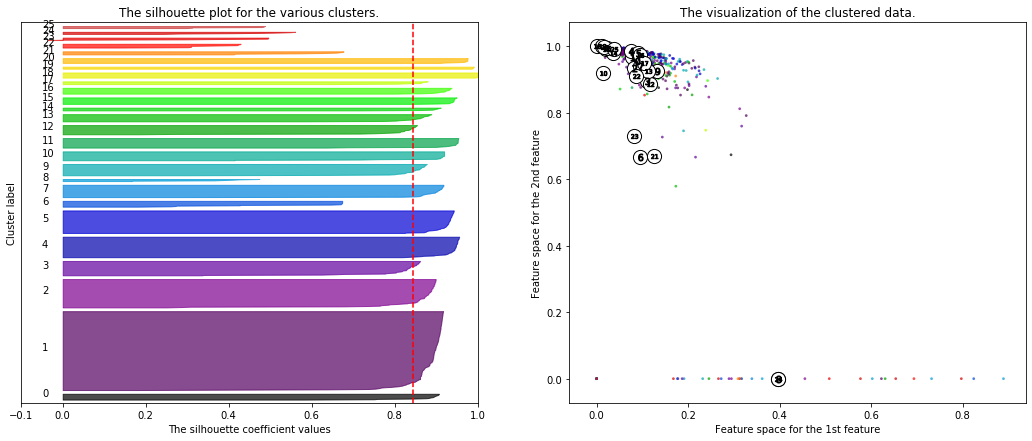

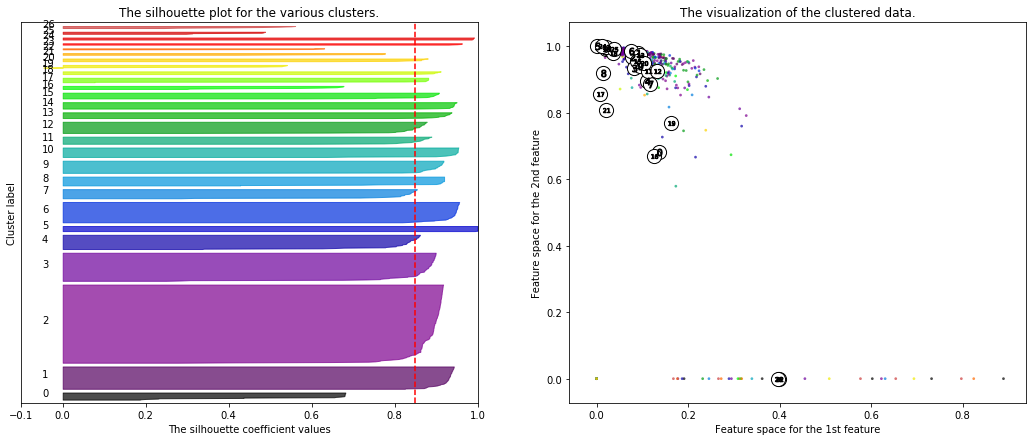

In [393]:
show_cluster(new_idea)

## & 5. Интерпритация результата

In [ ]:
X_test_clstrs = X_test_clstrs.sort_values('clusters')

In [ ]:
X_test_clstrs.groupby(['clusters'], as_index=False).mean()

In [1795]:
df = df3

In [96]:
df3

,Съедобный хлам,Солярка,Оружие,Ядер-Кола,Броня и одежда,Жидкости для тачки,Хлам,Патроны,Медпрепараты и еда,Бензак,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0.000092,0.000000,0.000000,0.000000e+00,0.000007,0.000003,0.000116,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,1,0,0,0
1,0.002208,0.168144,0.000000,0.000000e+00,0.000134,0.000032,0.000578,0.000000,0.000000,0.985760,...,0,0,0,0,0,0,1,0,0,0
2,0.014252,0.170219,0.000312,5.821388e-03,0.002664,0.000438,0.004939,0.078597,0.000384,0.982130,...,0,1,0,0,0,0,0,1,0,0
3,0.001383,0.103541,0.000001,2.157645e-07,0.000033,0.000573,0.000765,0.000000,0.000000,0.994624,...,0,0,0,0,1,0,0,0,1,0
4,0.012258,0.137891,0.000036,6.855079e-03,0.000585,0.000653,0.003383,0.033738,0.001589,0.989765,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,0.013707,0.198716,0.000622,9.116804e-03,0.002700,0.000866,0.006279,0.022609,0.005366,0.979618,...,0,0,0,0,0,0,1,0,0,0
841,0.013597,0.175535,0.000686,7.572002e-03,0.001612,0.000982,0.004801,0.027760,0.003974,0.983936,...,0,0,0,0,0,0,1,0,0,0
842,0.021839,0.212102,0.001175,1.703058e-02,0.002015,0.001725,0.005090,0.029397,0.008594,0.976356,...,0,0,0,0,0,0,1,0,0,0
843,0.013668,0.141825,0.000813,7.861145e-03,0.002083,0.000676,0.004365,0.034893,0.004297,0.989129,...,0,0,0,0,0,0,1,0,0,0
